# 캘리포니아 주택 가격 예측 모델 만들기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## 1. 데이터 가져오기

In [2]:
housing = pd.read_csv('./datasets/housing.csv')

## 2. 데이터 훑어보기

In [3]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**범주형 특성 탐색**

In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**수치형 특성 탐색**

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

**수치형 특성별 히스토그램**

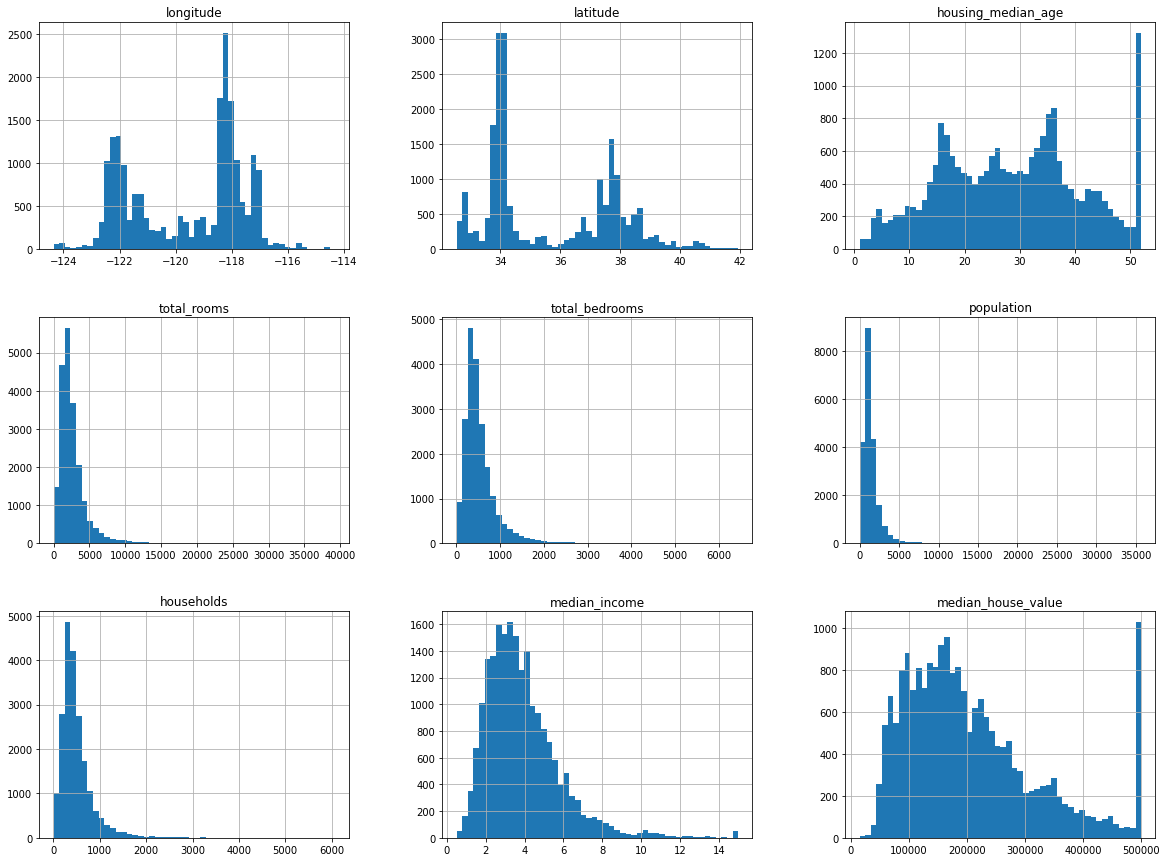

In [7]:
h = housing.hist(bins=50, figsize=(20, 15))

## 3. 데이터 세트 분리
- 훈련 데이터/ 테스트 데이터

**계층적 샘플링(Straityfied sampling)**

In [8]:
bins = [0, 1.5, 3.0, 4.5, 6.0, np.inf]
labels = [1, 2, 3, 4, 5]
housing['income_cat'] = pd.cut(housing['median_income'], bins=bins, labels=labels)

In [9]:
housing['median_income']

0        8.3252
1        8.3014
2        7.2574
3        5.6431
4        3.8462
          ...  
20635    1.5603
20636    2.5568
20637    1.7000
20638    1.8672
20639    2.3886
Name: median_income, Length: 20640, dtype: float64

In [10]:
housing['income_cat'].value_counts() # 도수

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [11]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
strat_train_set, strat_test_set = train_test_split(housing, stratify=housing['income_cat'], test_size=0.2, random_state=42)

In [14]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [15]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

**데이터 되돌리기**

In [16]:
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)

## 4. 데이터 탐색

**탐색적 데이터분석**
- 어떤 특성을 선택할지, 제거할지, 조합을 통해서 더 좋은 특성을 만들 수 있는지를 분석
- 시각화(데이터의 경향성, 왜곡, 특잇값, 통계적정보)
- 상관관계, 누락데이터(결측치)를 종합적으로 분석
- 탐색적 데이터 분석의 결과로 모델링 방향을 결정할 수 있음

In [17]:
# 훈련셋만을 대상으로 탐색과 시각화를 적용 (strat_test_set는 최종 예측에 사용)
housing = strat_train_set.copy()

### 4.1 지리적 데이터 시각화

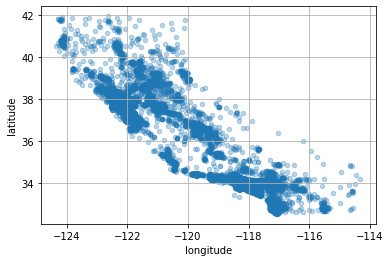

In [18]:
# longitude(경도) : 동서
# latitude(위도) : 남북
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3, grid=True)

In [19]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

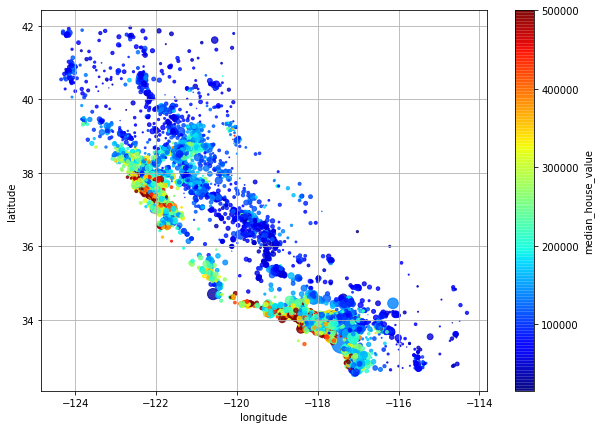

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.8, grid=True,
             c = 'median_house_value', cmap='jet', colorbar=True, figsize=(10, 7), # color 를 통해서 주택가격 표시
             s = housing['population']/100,  sharex=False) # size를 통해서 인구수를 표시

**지리적 데이터 분석결과**
: 해안가이면서 밀집 지역일수록 주택가격이 높음

### 4.2 상관관계 조사

- 상관계수

In [21]:
# 모든 수치형 특성간의 상관계수 확인
corr_matrix = housing.corr()
corr_matrix

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924478           -0.105823     0.048909   
latitude            -0.924478  1.000000            0.005737    -0.039245   
housing_median_age  -0.105823  0.005737            1.000000    -0.364535   
total_rooms          0.048909 -0.039245           -0.364535     1.000000   
total_bedrooms       0.076686 -0.072550           -0.325101     0.929391   
population           0.108071 -0.115290           -0.298737     0.855103   
households           0.063146 -0.077765           -0.306473     0.918396   
median_income       -0.019615 -0.075146           -0.111315     0.200133   
median_house_value  -0.047466 -0.142673            0.114146     0.135140   

                    total_bedrooms  population  households  median_income  \
longitude                 0.076686    0.108071    0.063146      -0.019615   
latitude                 -0.072550   -0.115290   -0.077765      -0.075146   
housing_median_age       -0.325101   -0.298737   -0.306473      -0.111315   
total_rooms               0.929391    0.855103    0.918396       0.200133   
total_bedrooms            1.000000    0.876324    0.980167      -0.009643   
population                0.876324    1.000000    0.904639       0.002421   
households                0.980167    0.904639    1.000000       0.010869   
median_income            -0.009643    0.002421    0.010869       1.000000   
median_house_value        0.047781   -0.026882    0.064590       0.687151   

                    median_house_value  
longitude                    -0.047466  
latitude                     -0.142673  
housing_median_age            0.114146  
total_rooms                   0.135140  
total_bedrooms                0.047781  
population                   -0.026882  
households                    0.064590  
median_income                 0.687151  
median_house_value            1.000000

In [22]:
# 중간 주택 가격(타깃)과 다른 특성간의 상관관계 확인

In [23]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

- 산점도

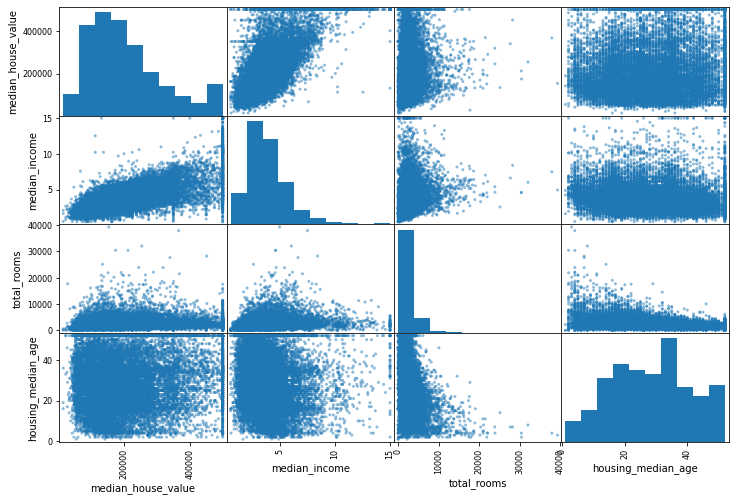

In [24]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

obj = pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show() # python script에서는 해줘야 함

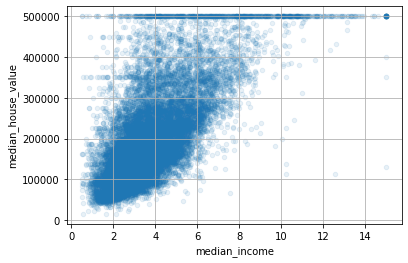

In [25]:
# 중간 주택 가격(타깃)과 중간소득의 산점도
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)

### 4.3 특성 조합을 실험

In [26]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [27]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_rooms         -0.259952
Name: median_house_value, dtype: float64

## 5. 데이터 전처리

In [28]:
# strat_train_set (시각화, 전처리)
# strat_test_set (최종 예측)

In [29]:
# 특성과 레이블을 분리
housing = strat_train_set.drop('median_house_value', axis=1) # 특성 (X 데이터)
housing_label = strat_train_set['median_house_value'].copy() # 레이블 (y 데이터)

### 5.1 데이터 전처리(1) - 결손값 처리

**결손값(Null/NaN) 처리 방법**

- 옵션1 : 해당 구역 제거
- 옵션2 : 전체 특성 삭제
- 옵션3 : 어떤 값으로 대체(0, 평균, 중간값 등)


**scikit-learn의 전처리기를 이용하여 옵션3 을 처리**

In [30]:
# <scikit-learn의 전처리기들 예시>
# preprocessing -> PolynomialFeatures 
# preprocessing -> StandardScaler
# impute -> SimpleImputer
# OneHotEncoder
# LabelEncoder, OrdinalEncoder
# MinMaxScaler
# 함수를 이용한 전처리 
# 나만의 전처리기

In [31]:
housing_num = housing.drop('ocean_proximity', axis=1)
# housing_num = housing.select_dtypes(include=[np.number])

In [32]:
# SimpleImputer를 결측값을 대체(옵션3) 할 수 있음
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median') # 변환기 객체 생성
imputer.fit(housing_num) # 변환할 준비 : 중앙값을 구함

SimpleImputer(strategy='median')

In [33]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [34]:
# 위의 statistics_ 값과 동일
housing_num.median()

longitude             -118.51000
latitude                34.26000
housing_median_age      29.00000
total_rooms           2119.00000
total_bedrooms         433.00000
population            1164.00000
households             408.00000
median_income            3.54155
dtype: float64

In [35]:
X = imputer.transform(housing_num) # 실제 변환

In [36]:
# housing_num_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
# housing_num_tr.info()

### 5.2 데이터 전처리(2) - 데이터 인코딩
- 데이터 인코딩을 하는 이유는 머신러닝에서 수치값만 기대하기 때문

In [37]:
housing_cat = housing[['ocean_proximity']] # 2차원의 dataframe으로 준비

#### (1) 레이블 인코딩

In [38]:
# pandas
pd.factorize(housing['ocean_proximity'])

(array([0, 1, 0, ..., 2, 2, 0]),
 Index(['INLAND', 'NEAR OCEAN', '<1H OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object'))

In [39]:
# scikit-learn 변환기
from sklearn.preprocessing import OrdinalEncoder # LabelEncoder는 1차원 데이터를 기대

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit_transform(housing_cat)

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

#### (2) 원핫 인코딩
숫자의 크기가 모델 훈련과정에서 잘못된 영향을 줄 수 있으므로 원핫 인코딩

In [40]:
# pandas
pd.get_dummies(housing_cat)

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
12655                          0                       1   
15502                          0                       0   
2908                           0                       1   
14053                          0                       0   
20496                          1                       0   
...                          ...                     ...   
15174                          1                       0   
12661                          0                       1   
19263                          1                       0   
19140                          1                       0   
19773                          0                       1   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
12655                       0                         0   
15502                       0                         0   
2908                        0                         0   
14053                       0                         0   
20496                       0                         0   
...                       ...                       ...   
15174                       0                         0   
12661                       0                         0   
19263                       0                         0   
19140                       0                         0   
19773                       0                         0   

       ocean_proximity_NEAR OCEAN  
12655                           0  
15502                           1  
2908                            0  
14053                           1  
20496                           0  
...                           ...  
15174                           0  
12661                           0  
19263                           0  
19140                           0  
19773                           0  

[16512 rows x 5 columns]

In [41]:
# scikit-learn 변환기
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit_transform(housing_cat)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [42]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 5.3 데이터 전처리(3) - 특성 스케일링
- 표준화 (Z score Standardize) : 평균 0, 표준편차 1
- 정규화 (Min Max Scaling) : 0~1 사이로 정규화 (참고 : 특잇값에 영향을 받음)
- 로그 스케일링 : 데이터의 분포가 왜곡되어 있을때 주로 사용

In [43]:
arr = np.arange(9).reshape(3,3)

In [44]:
Z_arr = (arr - arr.mean())/arr.std() # 표준화 공식
Z_arr.mean(), Z_arr.std()

(0.0, 1.0)

In [45]:
M_arr = (arr - arr.min())/(arr.max()- arr.min()) # 정규화(0~1) 공식
M_arr.min(), M_arr.max()

(0.0, 1.0)

In [46]:
# pandas
def minmax_normalize(arr):
    return (arr-arr.min())/(arr.max()-arr.min())

def zscore_standize(arr): # 평균 0, 표준편차 1
    return (arr - arr.mean())/arr.std()    

In [47]:
# scikit-learn 변환기

In [48]:
# 표준화 (Z score Standardize) : 평균 0, 표준편차 1
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std = std_scaler.fit_transform(housing_num)
housing_num_std.mean(0), housing_num_std.std(0) # 0번축으로 각각의 컬럼별 평균/표준편차

(array([-5.24924634e-15,  2.81159678e-16,  8.77850764e-17, -1.54914841e-17,
                    nan,  6.45478503e-19, -1.05428155e-17,  1.14841384e-16]),
 array([ 1.,  1.,  1.,  1., nan,  1.,  1.,  1.]))

In [49]:
# 정규화 (Min Max Scaling) : 0~1 사이로 정규화 (참고 : 특잇값에 영향을 받음)
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1)) # feature_range=(0, 1)가 기본값, 변경 가능
housing_num_mm = min_max_scaler.fit_transform(housing_num)
housing_num_mm.min(0), housing_num_mm.max(0)

(array([ 0.,  0.,  0.,  0., nan,  0.,  0.,  0.]),
 array([ 1.,  1.,  1.,  1., nan,  1.,  1.,  1.]))

In [50]:
# 로그 스케일링 : 데이터의 분포가 왜곡되어 있을때 주로 사용
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log)
log_population = log_transformer.fit_transform(housing_num[['population']])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd70337ac10>]],
      dtype=object)

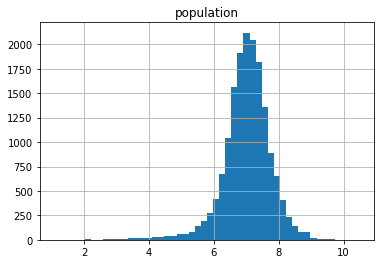

In [51]:
log_population.hist(bins=50) # 변환후

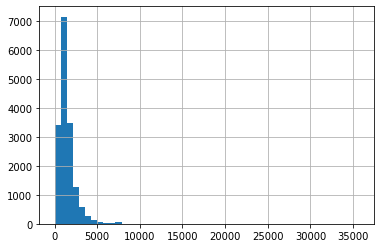

In [52]:
housing_num['population'].hist(bins=50) # 변환전

### 5.4 데이터 전처리(4) - 변환 파이프라인

In [53]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [54]:
# 수치형 데이터를 위한 파이프라인

# 누락된 데이터를 중앙값으로 대체
# ---> 표준화

from sklearn.pipeline import Pipeline 

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('std_scaler', StandardScaler())
                        ])
# num_pipeline.fit_transform(housing_num)

In [55]:
# 범주형 데이터를 위한 파이프라인
# --> 원핫 인코딩

In [56]:
num_attribs = list(housing_num.columns.values)
cat_attrib = ['ocean_proximity']

In [57]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([('num_pipeline', num_pipeline, num_attribs),
                                   ('onehot_encoder', OneHotEncoder(), cat_attrib)])


In [58]:
housing_prepared = full_pipeline.fit_transform(housing)

In [59]:
housing_prepared.shape

(16512, 13)

In [60]:
housing.shape

(16512, 9)

## 6. 모델 선택과 훈련

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [66]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)

In [63]:
# cross_val_score(모델, 특성, 정답, 성능측정지표, 폴드수)

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
lin_rmse = np.sqrt(-lin_scores).mean()
lin_rmse

69204.32275494764

In [67]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
tree_rmse = np.sqrt(-tree_scores).mean()
tree_rmse

69081.361562518

In [69]:
rf_scores = cross_val_score(rf_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rf_rmse = np.sqrt(-rf_scores).mean()
rf_rmse

49432.12678796127

## 7. 모델 세부 튜닝

**그리드 탐색**

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
rf_reg = RandomForestRegressor(random_state=42)

In [72]:
param_grid = {'n_estimators':[30, 50, 100], 'max_features':[2, 4, 6, 8]} # 3*4 

# GridSearchCV(모델, 탐색할파라미터, 성능측정기준, 폴드수)
grid_search = GridSearchCV(rf_reg, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1) # 3*4*5
%time grid_search.fit(housing_prepared, housing_label)

CPU times: user 6.5 s, sys: 140 ms, total: 6.64 s
Wall time: 1min 25s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [30, 50, 100]},
             scoring='neg_mean_squared_error')

In [73]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 100}

In [74]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, random_state=42)

In [79]:
for mean_score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
  print(np.sqrt(-mean_score), params)

52673.5498401615 {'max_features': 2, 'n_estimators': 30}
52071.46113915598 {'max_features': 2, 'n_estimators': 50}
51527.67198141185 {'max_features': 2, 'n_estimators': 100}
50370.55528306362 {'max_features': 4, 'n_estimators': 30}
49981.14659922965 {'max_features': 4, 'n_estimators': 50}
49582.79646511731 {'max_features': 4, 'n_estimators': 100}
50177.91173851986 {'max_features': 6, 'n_estimators': 30}
49655.44617680634 {'max_features': 6, 'n_estimators': 50}
49366.1574509085 {'max_features': 6, 'n_estimators': 100}
49941.11534754462 {'max_features': 8, 'n_estimators': 30}
49485.628343968834 {'max_features': 8, 'n_estimators': 50}
49160.66522746081 {'max_features': 8, 'n_estimators': 100}


**랜덤 탐색**

In [81]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators' : randint(low=1, high=200), 'max_features' : randint(low=1, high=8)}


# RandomizedSearchCV(모델, 탐색할파라미터, 반복횟수, 성능측정기준, 폴드수)
rnd_search = RandomizedSearchCV(rf_reg, param_distribs, n_iter=10, scoring='neg_mean_squared_error', cv=5, n_jobs=-1) # 10*5
%time rnd_search.fit(housing_prepared, housing_label)

CPU times: user 9.74 s, sys: 208 ms, total: 9.94 s
Wall time: 1min 52s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6fa995580>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6fa782280>},
                   scoring='neg_mean_squared_error')

In [82]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 165}

In [91]:
best_model = rnd_search.best_estimator_

In [83]:
for mean_score, params in zip(rnd_search.cv_results_['mean_test_score'], rnd_search.cv_results_['params']):
  print(np.sqrt(-mean_score), params)

50454.589664971325 {'max_features': 6, 'n_estimators': 23}
53680.00193306822 {'max_features': 1, 'n_estimators': 111}
53460.256025914845 {'max_features': 1, 'n_estimators': 175}
49982.0858131801 {'max_features': 5, 'n_estimators': 37}
49605.97930820139 {'max_features': 4, 'n_estimators': 97}
49495.31732215806 {'max_features': 4, 'n_estimators': 179}
50185.76692995595 {'max_features': 3, 'n_estimators': 158}
53659.879898364925 {'max_features': 1, 'n_estimators': 126}
49476.64676115237 {'max_features': 5, 'n_estimators': 104}
49123.155820470216 {'max_features': 7, 'n_estimators': 165}


## 8. 모델 예측과 성능 평가

In [86]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test.shape, y_test.shape

((4128, 9), (4128,))

In [89]:
# 훈련데이터를 변경할때는 파이프라인의 fit_transform()을 사용
# 테스트데이터를 변경할때는 파이프라인의 transform()을 사용

X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared.shape

(4128, 13)

In [92]:
final_predictions = best_model.predict(X_test_prepared)

In [93]:
from sklearn.metrics import mean_squared_error

final_rmse = mean_squared_error(y_test, final_predictions, squared=False) # RMSE
final_rmse

46508.02771914554

In [97]:
full_pipeline_with_predictor = Pipeline([
                                  ('preparation', full_pipeline),
                                  ('final', best_model)
                              ])

## 9. 모델 저장

In [98]:
import joblib

joblib.dump(full_pipeline_with_predictor, 'my_model.pkl')

['my_model.pkl']

In [99]:
loaded_model = joblib.load('my_model.pkl')

In [101]:
final_predictions2= loaded_model.predict(X_test)

In [103]:
mean_squared_error(y_test, final_predictions2, squared=False)

46508.02771914554